In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [41]:
im1='4.jpg'
im2='5.jpg'
#im2='frank.jpg'
#im2='ghasemi.jpg'
#im1='damiano.jpg'


In [42]:
# Function to show two images
def showTwoIm(im1, im2):
    plt.figure(figsize=(28, 14))
    plt.subplot(1,2,1)
    plt.imshow(im1,cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(im2,cmap='gray')
    plt.axis('off')
    plt.show()

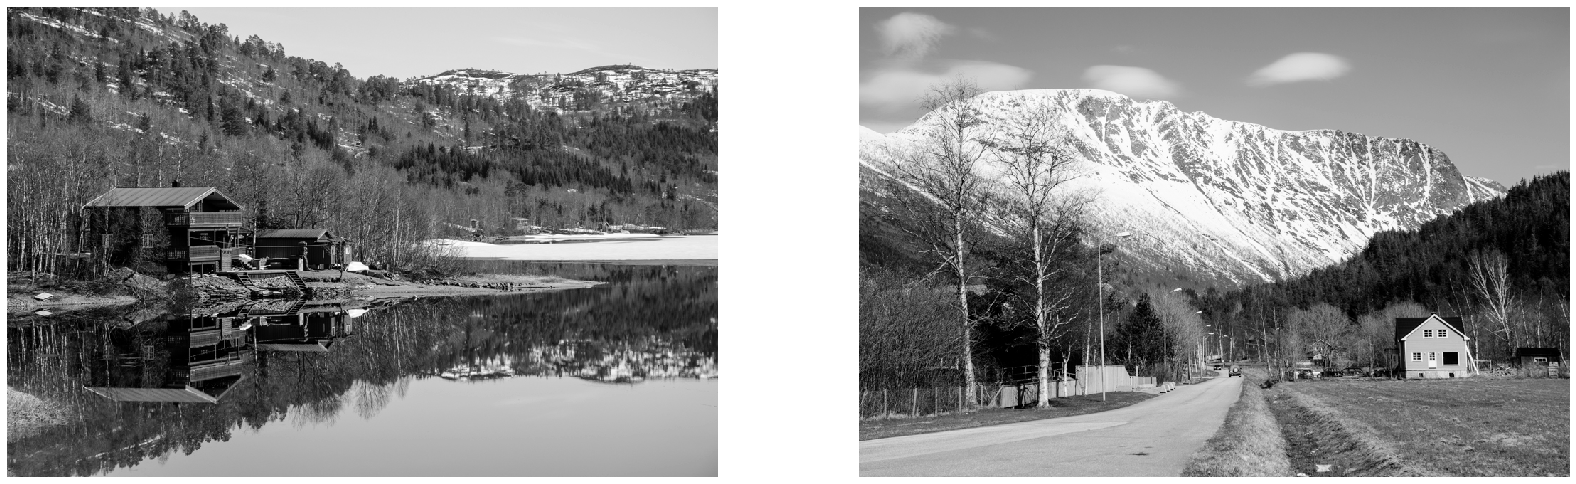

In [43]:
# Original images
S1 = cv2.imread(im1,0)
S2 = cv2.imread(im2,0)
m,n = S1.shape
showTwoIm(S1, S2)

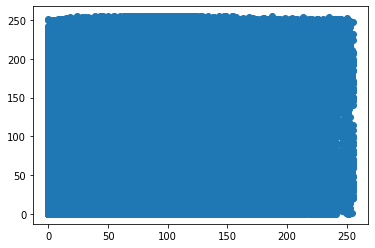

In [44]:
plt.scatter(S1.flatten(),S2.flatten())

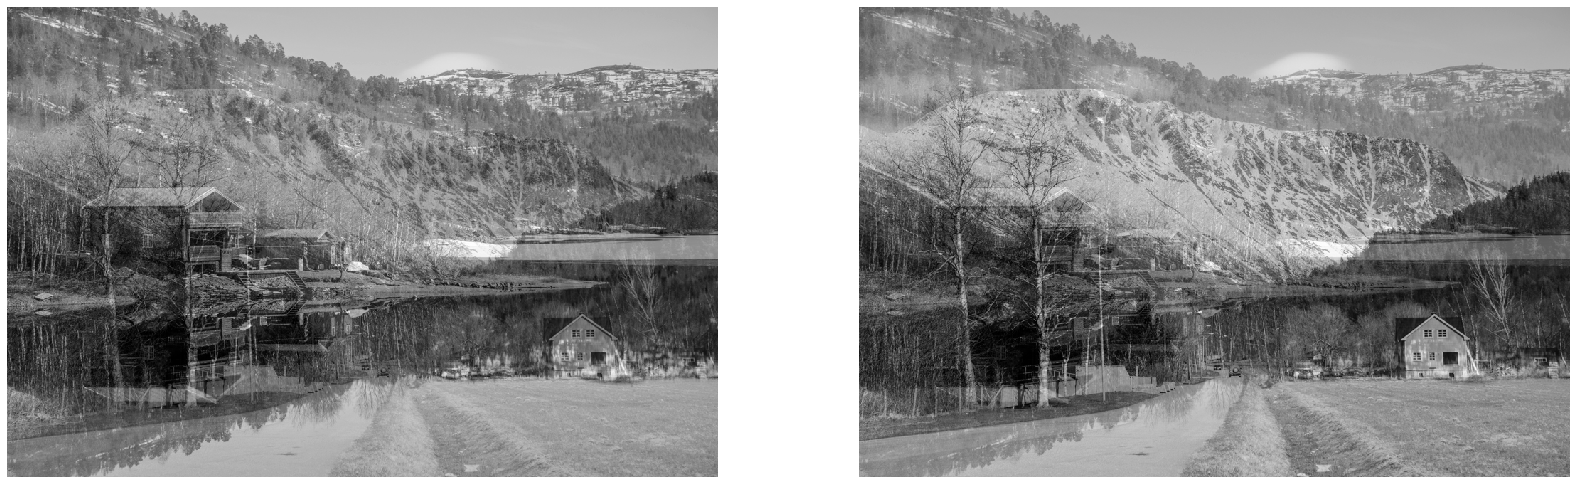

In [45]:
# Mixing them
w = np.array([[0.6, 0.4], [0.4, 0.6]])

X1 = w[0,0]*S1 + w[0,1]*S2
X2 = w[1,0]*S1 + w[1,1]*S2

showTwoIm(X1, X2)

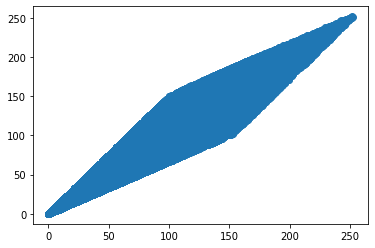

In [46]:
plt.scatter(X1.flatten(),X2.flatten())

### Step 1: Rotation of the parallelogram 
Finding the angle with maximal variance

Variance at an arbitrary angle of orientation:
$$Var(\theta)=\sum_{j=1}^{N}\left\{ [x_1(j) \quad x_2(j)] \begin{bmatrix}
cos \theta  \\
sin \theta \end{bmatrix} \right\}^2 $$
Differentiating with respect to $\theta$ 
$$ d\frac{Var(\theta)}{d \theta}=\sum_{j=1}^{N}[x_2^2(j)-x_1^2(j)]sin(2\theta)+2x_1(j)x_2(j)cos(2\theta)$$
Setting $ d\frac{Var(\theta)}{d \theta}=0$
$$\theta_o =\frac{1}{2}tan^{-1}\left [  \frac{-2\sum_{j=1}^{N}x_1(j)x_2(j)}{\sum_{j=1}^{N}[x_2^2(j)-x_1^2(j)]}  \right]$$

In [47]:
# make it a vector and center data around mean

M, N = X1.shape

x1 = X1.reshape(M*N, 1) 
x2 = X2.reshape(M*N, 1)

x1v = x1 - np.mean(x1) 
x2v = x2 - np.mean(x2)

theta0 = 0.45*np.arctan( -2*np.sum(x1v*x2v) / np.sum(x1v**2-x2v**2) ); # compute 1st principal direction
print("Theta = ",theta0*180/np.pi)

Theta =  40.28332986410133


$$U^{*}=\begin{bmatrix}
cos\theta_o & sin \theta_o \\
-sin \theta_o & cos \theta_o 
\end{bmatrix}$$

In [48]:
Ustar = np.array([[np.cos(theta0), np.sin(theta0)], 
               [-np.sin(theta0), np.cos(theta0)]])

### Step 2: Scaling of parallelogram

Finding the scaling of the principal components
Variance along the two principal compoment axes:
$$\sigma_1=\sum_{j=1}^{N}\left\{[x_1(j)\quad x_2(j)] \begin{bmatrix}
cos\theta_o  \\
sin \theta_o \end{bmatrix}  \right\}^2$$
$$\sigma_2=\sum_{j=1}^{N}\left\{[x_1(j)\quad x_2(j)] \begin{bmatrix}
cos(\theta_o -\pi/2) \\
sin(\theta_o -\pi/2) \end{bmatrix}  \right\}^2$$

In [49]:
sigma1 = np.sum( (x1v*np.cos(theta0) + x2v*np.sin(theta0))**2 )
sigma2 = np.sum( (x1v*np.cos(theta0-np.pi/2) + x2v*np.sin(theta0 - np.pi/2))**2 )

In [50]:
print("sigma = ",sigma1/sigma2,sigma2/sigma2)

sigma =  24.3253445145372 1.0


To undo the scaling:
$$\Sigma^{-1}=\begin{bmatrix}
1/\sqrt{\sigma_1} & 0 \\
0 & 1/\sqrt{\sigma_2} \end{bmatrix}$$

In [51]:
Sigma_inv = np.array([[1/np.sqrt(sigma1), 0], 
                      [0, 1/np.sqrt(sigma2)]])

In [52]:
X1bar = (Ustar[0,0]*X1+Ustar[0,1]*X2)
X2bar = (Ustar[1,0]*X1+Ustar[1,1]*X2)

### Step 3: Rotation to produce a separable probability distribution
$$kurt(\phi)=K(\phi)=\sum_{j=1}^{N}\left\{ [\bar{x}_1(j) \quad \bar{x}_2(j)] \begin{bmatrix}
cos \phi  \\
sin \phi \end{bmatrix} \right\}^4 $$

$$\bar{K}(\phi)=\sum_{j=1}^{N} \frac{1}{\bar{x}_1^{2}(j)+\bar{x}_2^{2}(j)}  \left\{ [\bar{x}_1(j) \quad \bar{x}_2(j)] \begin{bmatrix}
cos \phi  \\
sin \phi \end{bmatrix} \right\}^4 $$

$$\frac{d\bar{K}(\phi)}{d \phi}=0$$
gives
$$\phi_o=\frac{1}{4}tan^{-1}\left [ \frac{-\Sigma_{j=1}^{N}[2\bar{x}_1^3(j)\bar{x}_2(j)-2\bar{x}_1(j)\bar{x}_2^3(j)]/[\bar{x}_1^2(j)+x_2^2(j)]}{\Sigma_{j=1}^{N} [3\bar{x}_1^2(j)\bar{x}_2^2(j)-(1/2)\bar{x}_1^4(j)-(1/2)\bar{x}_2^4(j)]/[\bar{x}_1^2(j)+\bar{x}_2^2(j)]} \right ]
$$

In [53]:
X1bar = Sigma_inv[0,0]*X1bar
X2bar = Sigma_inv[1,1]*X2bar

In [54]:
x1vbar = X1bar.reshape(M*N, 1)
x2vbar = X2bar.reshape(M*N, 1)

phi0 = 0.82*np.arctan( -np.sum(2*(x1vbar**3)*x2vbar-2*x1vbar*(x2vbar**3)) / 
                    np.sum(3*(x1vbar**2)*(x2vbar**2)-0.5*(x1vbar**4)-0.5*(x2vbar**4)))

V = np.array([[np.cos(phi0), np.sin(phi0)],
              [-np.sin(phi0), np.cos(phi0)]])

m1 = V[0,0]*X1bar+V[0,1]*X2bar
m2 = V[1,0]*X1bar+V[1,1]*X2bar

S1_hat = (m1 - np.min(m1))/(np.max(m1) - np.min(m1))
S2_hat = (m2 - np.min(m2))/(np.max(m2) - np.min(m2))

# Showing results

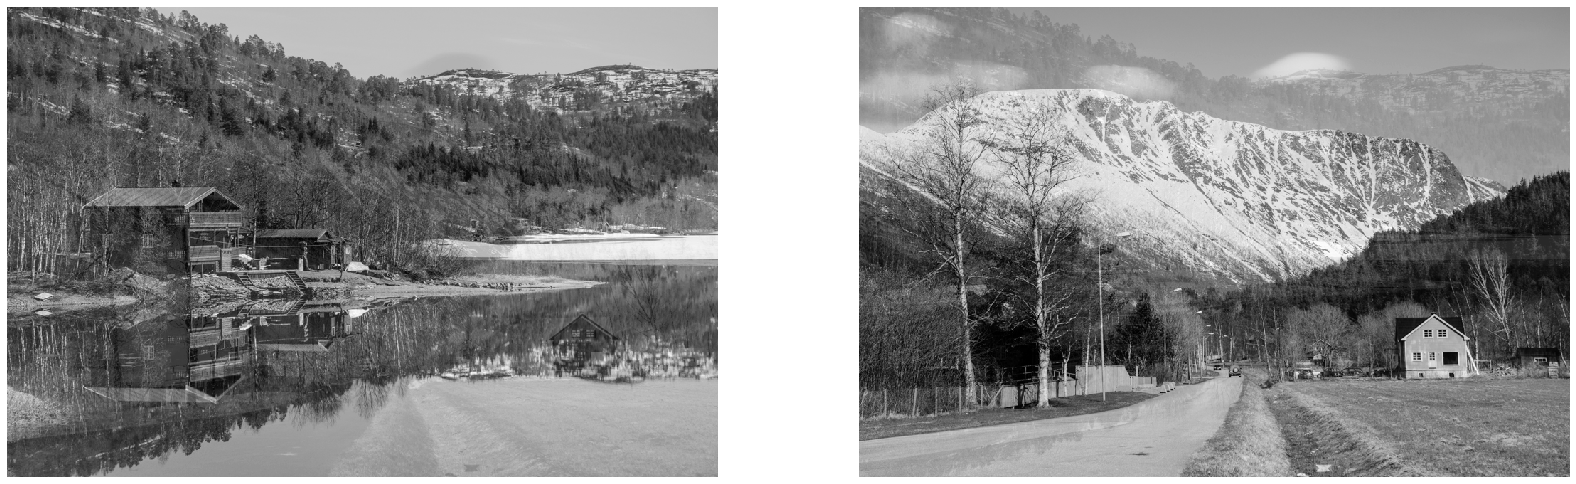

In [55]:
showTwoIm(S1_hat, S2_hat)

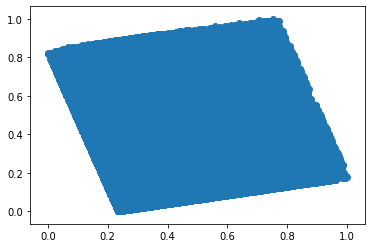

In [56]:
plt.scatter(S1_hat.flatten(),S2_hat.flatten())

# Comparing with original

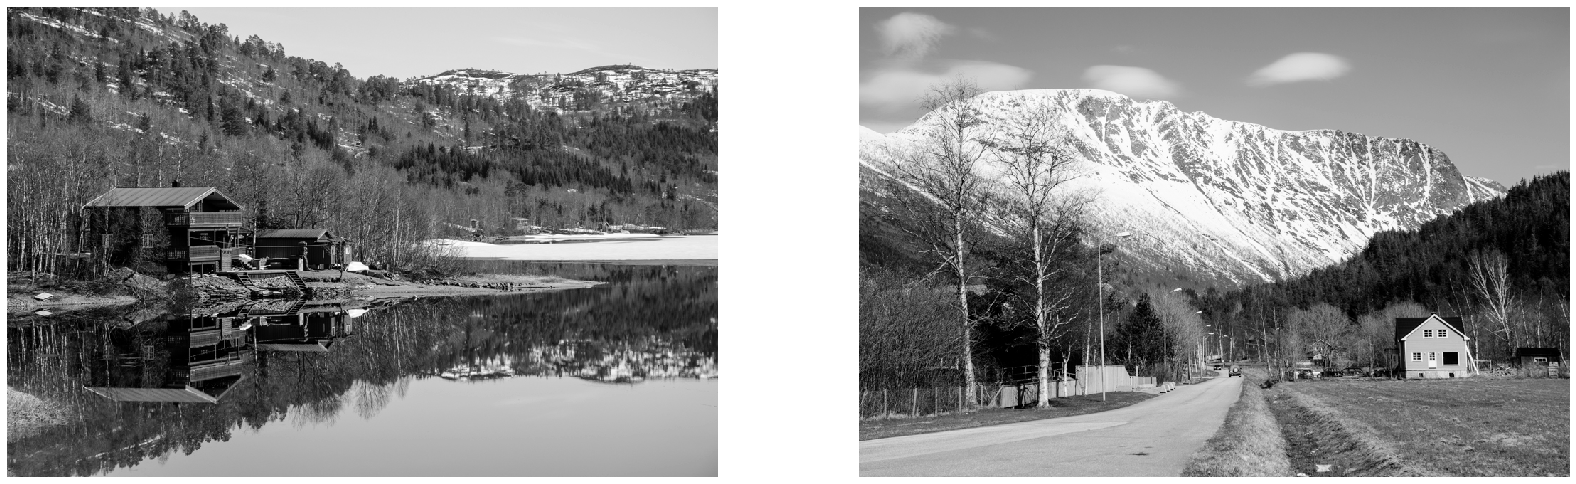

In [57]:
showTwoIm(S1, S2)

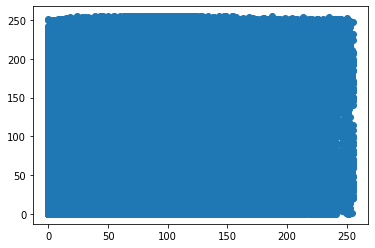

In [58]:
plt.scatter(S1.flatten(),S2.flatten())